In [1]:
### 前回からの修正点
# ・特徴点の選出パターン作成（片方座標のみ，or両方の座標の平均）
# ・変数名修正
# ・新しい解析フォルダに切り替えた時に必要なフォルダ作成（動作は未確認）
# ・データシート2種類作成(datasheet_all, datasheet_202212〇〇_tanaka_pattern〇)(ALL or per INFO)（動作未確認）
# ・csvモジュールをすべてpandasに変更

In [2]:
import os
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.metrics import r2_score
import pandas as pd
import math

In [3]:
##### データフォルダ・データシート作成（データフォルダが存在しない場合のみ実行）

current_directory = os.getcwd().replace(os.sep, "/")
print("current_directory: " + current_directory)

data_path = current_directory + "/Data"
print("data_path: " + data_path)

datasheet_ver = 2
datasheet_all_path = data_path + "/datasheet_ver" + str(datasheet_ver) + ".csv"
# datasheet_all_path = data_path + "/datasheet_all" + ".csv"
print("datasheet_all_path: " + datasheet_all_path)

cols_for_all = ["No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Additional Info", "Modified_Info", "Trial Num", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", 
        "Max Corners", "Quality Level", "Min Distance", "Block Size", "Trim Width", "Trim Height", "RMSE", "R2", "Corrcoef", "Updated Date"]
# cols_for_all = ["No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "RMSE", "R2", "Corrcoef", "Updated Date"]


# データフォルダが存在しなければ作成
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print("Data folder was successfully created.")
else:
    print("Data folder already exists.")

# datasheet_allが存在しなければ作成
if not os.path.exists(datasheet_all_path):
    df_for_all = pd.DataFrame(columns=cols_for_all)
    # datasheet_allへの新規書き込み
    df_for_all.to_csv(datasheet_all_path, encoding="shift_jis", index=False)
    print("datasheet_all was successfully created.")
    
else:
    print("Datasheet already exists.")

current_directory: C:/Users/katagi/Desktop/Research/UltrasoundImaging
data_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data
datasheet_all_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/datasheet_ver2.csv
Data folder already exists.
Datasheet already exists.


In [4]:
#   要修正

### ターゲットのデータがデータシートに既に記入されているか（一度同じ条件で解析されているか）を確認

datasheet_all = pd.read_csv(datasheet_all_path, header=0, encoding='shift_jis')
# print(datasheet_all)


In [5]:
#    要修正

### ターゲットのデータがなければデータシートに記入
# print(target_data_block.empty)
# if not target_data_block.empty:

In [6]:
#### ターゲットデータ取得（1個）

# データナンバー
##この値を変えると自動的に、実験日、被験者、実験パターン、試行No.を抽出する
# ※ 解析対象を変更するときは、この番号だけ変えればよい
data_No = 187
# 182 - 191
# 7 - 11

target_data = datasheet_all.loc[datasheet_all.No == data_No].copy()
print('--target_data-----------')
print(target_data)
print('------------------------')


print('--target_data information--')
## INFO
# 実験日
date = str(int(target_data["Date"].iloc[0]))
print("date            : " + date)

# 被験者
subject = str(target_data["Subject"].iloc[0])
print("subject         : " + subject)

# 実験パターン
pattern = int(target_data['Pattern'].iloc[0])
print("pattern         : " + str(pattern))

# 補足
additional_info = str(target_data["Additional Info"].iloc[0])
if additional_info == "nan":
    additional_info = ""
print("additional_info : " + additional_info)

# 修正情報
modified_info = str(target_data["Modified Info"].iloc[0])
if modified_info == "nan":
    modified_info = ""
print("modified_info   : " + modified_info)

# 試行No.
trial_num = int(target_data["Trial Num"].iloc[0])
print("trial_num       : " + str(trial_num))


## SOFT PARAM
# 深度(mm)
depth = int(target_data["Depth"].iloc[0])
print("depth           : " + str(depth))

# ゲイン(%)
gain = int(target_data["Gain"].iloc[0])
print("gain            : " + str(gain))

# フォーカス
focus = str(target_data["Focus"].iloc[0])
print("focus           : " + str(focus))

# 周波数(MHz)
frequency = int(target_data["Frequency"].iloc[0])
print("frequency       : " + str(frequency))

# ダイナミックレンジ(dB)
dynamic_range = int(target_data["Dynamic Range"].iloc[0])
print("dynamic_range   : " + str(dynamic_range))


## PATH
# ゴニオ（関節角度）データファイル名
gonio_file = str(target_data["Gonio"].iloc[0])
print("gonio_file      : " + str(gonio_file))

# エコー動画ファイル名
echo_file = str(target_data["Echo"].iloc[0])
print("echo_file       : " + str(echo_file))



print('---------------------------')


# 深度によってフレームレートとトリミングする範囲が変わる
depth_param = {20 : [73, [70, 1100]], 30 : [62, [85, 1085]], 40 : [54, [200, 970]], 50 : [48, [280, 890]], 60 : [43, [325, 845]]}
# Depth:              20          30         40         50         60
# Frame Rate:         73          62         54         48         43
# Triming Range:  [70, 1100] [85, 1085] [200, 970] [280, 890] [325, 845]




data_per_info_path = current_directory + "/Data/" + date + "_" + subject + "_" + additional_info

# info_str = date + "_" + subject + "_pattern" + str(pattern)
# data_per_info_path = data_path + "/" + info_str
print("data_per_info_path: " + data_per_info_path)

--target_data-----------
      No        Date Subject  Pattern  Additional Info  Modified Info  \
5  187.0  20221108.0  Katagi      1.0              NaN            NaN   

   Trial Num  Unnamed: 7  Depth  Gain Focus  Frequency  Dynamic Range  \
5        6.0         NaN   30.0  40.0  7_17        7.0           36.0   

   Unnamed: 13             Gonio                 Echo  Unnamed: 16      RMSE  \
5          NaN  202211081352.csv  20221108 135205.mp4          NaN  6.721109   

         R2  Corrcoef  
5  0.862314   0.96942  
------------------------
--target_data information--
date            : 20221108
subject         : Katagi
pattern         : 1
additional_info : 
modified_info   : 
trial_num       : 6
depth           : 30
gain            : 40
focus           : 7_17
frequency       : 7
dynamic_range   : 36
gonio_file      : 202211081352.csv
echo_file       : 20221108 135205.mp4
---------------------------
data_per_info_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/202211

In [7]:
##### 解析パス設定
### 解析結果の図や途中の処理データを上書きしたくないときはここで切り替える
### 最初の解析では analysis_num = 1 を指定する

analysis_num = 3
analysis_path = data_per_info_path + "/Analysis" + str(analysis_num)
print(analysis_path)


# 最初の解析の時には，以下のフォルダ・データシートを作成

# # data_per_info フォルダ直下にdatasheet_per_infoを作成
# datasheet_per_info_path = data_per_info_path + "/datasheet_" + info_str + ".csv"
# cols_per_info = ["No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "FP Selection Pattern", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", 
#         "Max Corners", "Quality Level", "Min Distance", "Block Size", "Trim Width", "Trim Height", "RMSE", "R2", "Corrcoef", "Updated Date"]
# if not os.path.exists(datasheet_per_info_path):
#     df_per_info = pd.DataFrame(columns=cols_per_info)
#     # datasheet_per_infoへの新規書き込み
#     df_per_info.to_csv(datasheet_per_info_path, encoding="shift_jis", index=False)
#     print("datasheet_" + info_str + " was successfully created.")
    
# EchoData フォルダ直下に新しいフォルダを作成
preprocessed_movie_path = data_per_info_path + "/EchoData/PreprocessedMovie"
if not os.path.exists(preprocessed_movie_path):
    os.makedirs(preprocessed_movie_path)

# GonioData フォルダ直下に新しいフォルダを作成
preprocessed_gonio_path = data_per_info_path + "/GonioData/PreprocessedGonio"
if not os.path.exists(preprocessed_gonio_path):
    os.makedirs(preprocessed_gonio_path)


C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis3


In [8]:
##### 必要フォルダ作成
### 新しい解析パスを指定した場合，解析パス直下に必要なフォルダを作成する

    
if not os.path.exists(analysis_path):
    
    # analysis_path フォルダを作成
    os.makedirs(analysis_path)
    
    # analysis_path フォルダ直下に新しいフォルダを作成
    processed_data_path = analysis_path + "/ProcessedData"
    results_path = analysis_path + "/Results"
    os.makedirs(processed_data_path)
    os.makedirs(results_path)
    
    # ProcessedData フォルダ直下に新しいフォルダを作成
    echo_processed_path = processed_data_path + "/EchoProcessed"
    gonio_processed_path = processed_data_path + "/GonioProcessed"
    os.makedirs(echo_processed_path)
    os.makedirs(gonio_processed_path)
    
    ## EchoProcessed フォルダ直下に新しいフォルダを作成
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    echo_raw_vs_filtered_path = echo_processed_path + "/EchoRawVSFiltered"
    # フィルターをかけた後の特徴点データを保存する場所
    filtered_fp_path = echo_processed_path + "/FilteredFP"
    # 選出した特徴点データ（解析用）を保存する場所
    fp_for_analysis_path = echo_processed_path + "/FPForAnalysis"
    # 選出した特徴点データ（描画用）を保存する場所
    fp_for_visualize_path = echo_processed_path + "/FPForVisualize"
    # オプティカルフローの動画を保存する場所
    opticalflow_movie_path = echo_processed_path + "/OpticalflowMovie"
    
    os.makedirs(echo_raw_vs_filtered_path)
    os.makedirs(filtered_fp_path)
    os.makedirs(fp_for_analysis_path)
    os.makedirs(fp_for_visualize_path)
    os.makedirs(opticalflow_movie_path)
    
    
    ## GonioProcessed フォルダ直下に新しいフォルダを作成
    # フィルターをかけた後の関節角度データを保存する場所
    filtered_theta_path = gonio_processed_path + "/FilteredTheta"
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    gonio_raw_vs_filtered_path = gonio_processed_path + "/GonioRawVSFiltered"
    
    os.makedirs(filtered_theta_path)
    os.makedirs(gonio_raw_vs_filtered_path)
    
    
    ## Results フォルダ直下に新しいフォルダ・結果用csvファイルを作成
    # 関節角度の実測値と推定値の比較グラフを保存する場所
    angle_estimation_path = results_path + "/AngleEstimation"
    # 特徴点の挙動を示す図を保存する場所
    fp_behavior_path = results_path + "/FPBehavior"
    
    os.makedirs(angle_estimation_path)
    os.makedirs(fp_behavior_path)
    
    print("All folders were successfully created.")


else:
    print(analysis_path + " folder already exists.")

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis3 folder already exists.


In [9]:
##### パラメータ


### ゴニオデータ処理用 パラメータ

gonio_frame_rate = 100
echo_frame_rate = depth_param[depth][0]
# 計測時間(s)
start_time = 12
end_time = 56
total_time = end_time - start_time
numOfData = echo_frame_rate * total_time
interpolate_rate = gonio_frame_rate * echo_frame_rate

# csvファイル内の目的データの開始位置

start_row = gonio_frame_rate * start_time
end_row = gonio_frame_rate * end_time -1
target_column = 1

# ローパスフィルタ パラメータ
fp = 1.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs = 7.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

time = np.linspace(0, total_time, numOfData)

print("echo_frame_rate: " + str(echo_frame_rate))
print("numOfData: " + str(numOfData))
print("interpolate_rate: " + str(interpolate_rate))
print("start_row: " + str(start_row))
print("end_row: " + str(end_row))
print("time: ")
print(time, time.shape)



### エコーデータ処理用 パラメータ



# トリミング（元動画の超音波画像の部分のみに切り取る）
# 元動画サイズ：(1172, 608)
top, bottom = 40, 600
left, right = depth_param[depth][1][0], depth_param[depth][1][1]
# # トリミング後サイズ：(right - left, 560)
print("left, right: " + str(left) + ", " + str(right))

# 見切れ対策（最初の特徴点をトリミングした範囲内から抽出）(w:right - left, h:560)
# trim_w = 80
# trim_h = 60
trim_w = 80
trim_h = 150

# 特徴点数
feature_num = 50

## オプティカルフローパラメータ
# # (~2022/11/22/19:00)
# maxCorners=500       # 特徴点の最大数
# qualityLevel=0.15     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
# minDistance=15       # 特徴点間の最小距離
# blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ
# (~2022/11/)
maxCorners=1000       # 特徴点の最大数
qualityLevel=0.05     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=10       # 特徴点間の最小距離
blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ

# フレーム内へ角度情報を挿入する位置
wrist_angle_position = (40, 530)

### 解析用 パラメータ

# グラフ
min_height = -80
max_height = 30

# 正則化パラメータ
# lam = 0.1
lam = 1.0


echo_frame_rate: 62
numOfData: 2728
interpolate_rate: 6200
start_row: 1200
end_row: 5599
time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
left, right: 85, 1085


In [10]:
##### データ解析アルゴリズムパターン


### 特徴点選出パターン
# 1: 特徴点のx,y座標それぞれの相関係数を出し，その大きい方を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の相関係数の大きかった方の座標データのみを使用する．
# 2: 特徴点のx,y座標それぞれの相関係数を出し，その平均を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の両方の座標データを使用する．
# 3: 相関〇〇以上の特徴点のみ使用する
fp_selection_pattern = 1

print("fp_selection_pattern: " + str(fp_selection_pattern))

fp_selection_pattern: 1


In [11]:


##############################     ゴニオデータの処理     ##############################



In [12]:
##### ゴニオデータ関連パス設定

print("Target Gonio Data: " + gonio_file)

# データ読み込み用パス
# target_gonio_path = data_per_info_path + "/GonioData/" + gonio_file
target_gonio_file_path = data_per_info_path + "/GonioData/" + gonio_file

# データ前処理用パス
preprocessed_gonio_file_path = data_per_info_path + "/GonioData/PreprocessedGonio/" + gonio_file

# データ保存用パス
gonio_processed_path = analysis_path + "/ProcessedData/GonioProcessed"
filtered_theta_file_path = gonio_processed_path + "/FilteredTheta/" + gonio_file
gonio_raw_vs_filtered_file_path = gonio_processed_path + "/GonioRawVSFiltered/" + gonio_file.split(".")[0] + ".png"


Target Gonio Data: 202211081352.csv


In [13]:
##### 生データ読み込み

# preprocessed_gonio_file_path が存在しない場合実行
if not os.path.exists(preprocessed_gonio_file_path):
    gonio_raw = pd.read_csv(target_gonio_file_path, header=0, usecols=['Time', 'Gonio'])
    print(gonio_raw)

    print("------------------------------------")
    gonio_raw['Time'] = (gonio_raw['Time'] // 10) * 10
    print(gonio_raw)
    print("gonio_raw length: " + str(len(gonio_raw)))

else:
    print("preprocessed_gonio_path already exists.")

            Time      Gonio
0        22.9729  -5.289917
1        32.9191  -5.811768
2        43.0969  -5.344849
3        53.1317  -5.976563
4        63.2423  -4.603271
...          ...        ...
5824  59932.6600 -17.045290
5825  59942.6800 -18.006590
5826  59952.6600 -17.622070
5827  59963.0200 -16.798100
5828  59972.6700 -17.649540

[5829 rows x 2 columns]
------------------------------------
         Time      Gonio
0        20.0  -5.289917
1        30.0  -5.811768
2        40.0  -5.344849
3        50.0  -5.976563
4        60.0  -4.603271
...       ...        ...
5824  59930.0 -17.045290
5825  59940.0 -18.006590
5826  59950.0 -17.622070
5827  59960.0 -16.798100
5828  59970.0 -17.649540

[5829 rows x 2 columns]
gonio_raw length: 5829


In [14]:
##### ゴニオデータ補間

# preprocessed_gonio_file_path が存在しない場合実行
if not os.path.exists(preprocessed_gonio_file_path):
    
    gonio_col = ['Time', 'Gonio']
    gonio_rearranged_df = pd.DataFrame(columns=gonio_col)
    # print(gonio_rearranged_df)

    for row in gonio_raw.itertuples():
        # 計測開始時のラグを補完
        if row.Index == 0:
            start_modify_num = int(row.Time / 10)
            if start_modify_num >= 1:
                for i in range(start_modify_num):
                    new_time = i * 10.0
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

        # データが飛んでいるときに補間
        if row.Index >= 1:
            time_dif = row.Time - pre_time
            if time_dif == 0:
                continue
            if time_dif >= 20.0:
        #         print("----------------------------------")
        #         print("time_dif: " + str(time_dif))
        #         print("pre_time: " + str(pre_time))
        #         print("current_time: " + str(row.Time))
        #         print("pre_gonio: " + str(pre_gonio))
        #         print("current_gonio: " + str(row.Gonio))
                gonio_dif = row.Gonio - pre_gonio
                modify_num = int(time_dif / 10) - 1
                devide_num = modify_num + 1
                for i in range(modify_num):
                    new_time = pre_time + (time_dif) * ((i+1) / devide_num)
                    new_gonio = pre_gonio + (gonio_dif) * ((i+1) / devide_num)
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [new_gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        #             print("---------------------------")
        #             print("new_time: " + str(new_time))
        #             print("new_gonio: " + str(new_gonio))
        #             print("---------------------------")

        #         print("----------------------------------")

        #     if row.Index == 120:
        #         break

        new_df = pd.DataFrame(data={'Time': [row.Time], 'Gonio': [row.Gonio]})
        gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        # データ補間のために直前のデータとして保持
        pre_time = row.Time
        pre_gonio = row.Gonio

    # 計測終了時のデータ補間
    last_time = 59990.0
    last_time_dif = last_time - pre_time
    last_modify_num = int(last_time_dif / 10)
    if last_modify_num >= 1:
        for i in range(last_modify_num):
            new_time = pre_time + (i+1) * 10.0
            new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
            gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

    print("gonio_rearranged_df: ")
    print(gonio_rearranged_df)
    print(len(gonio_rearranged_df))

else:
    print("preprocessed_gonio_path already exists.")

gonio_rearranged_df: 
         Time      Gonio
0         0.0  -5.289917
1        10.0  -5.289917
2        20.0  -5.289917
3        30.0  -5.811768
4        40.0  -5.344849
...       ...        ...
5995  59950.0 -17.622070
5996  59960.0 -16.798100
5997  59970.0 -17.649540
5998  59980.0 -17.649540
5999  59990.0 -17.649540

[6000 rows x 2 columns]
6000


In [15]:
##### ゴニオ補間データの保存

gonio_rearranged_df.to_csv(preprocessed_gonio_file_path, encoding="shift_jis", index=False)
print("preprocessed_gonio file was successfully created.")

preprocessed_gonio file was successfully created.


In [16]:
##### ゴニオ補間データの読み込み

preprocessed_gonio_data = pd.read_csv(preprocessed_gonio_file_path, header=0, encoding='shift_jis')

start_time = 12
end_time = 56
# theta_raw = preprocessed_gonio_data.loc[start_row:end_row, 'Gonio'].to_numpy()
preprocessed_gonio_data = preprocessed_gonio_data.loc[start_row:end_row, 'Gonio'].to_numpy()
print("preprocessed_gonio_data: " + str(preprocessed_gonio_data))
print(preprocessed_gonio_data.shape)

preprocessed_gonio_data: [  1.054688    0.1208496   1.356812  ... -42.23145   -42.5885
 -42.53357  ]
(4400,)


In [17]:
# print(stop)

In [18]:
##### フレームレート調整

# gonioとechoのフレームレートを合わせる
# gonioデータを補完(interpolate)しエコーデータにあわせてリサンプリングする
# 参考ページ: https://watlab-blog.com/2019/09/19/resampling/

t0 = 0    # 初期時間[s]
dt = 1/gonio_frame_rate  # 時間刻み[s] 1/100
t = np.arange(t0, total_time, dt)

interpolate_num = interpolate_rate * total_time
t_interpolate = np.linspace(t0, total_time - dt, interpolate_num)

# 補間
f = interpolate.interp1d(t, preprocessed_gonio_data, kind="cubic")
interpolated_theta = f(t_interpolate)

# リサンプリング
resampled_theta = list()
for i in range(len(interpolated_theta)):
    if i % gonio_frame_rate == 0:
        resampled_theta.append(interpolated_theta[i])
    if (len(resampled_theta)) >= numOfData:
        break

resampled_theta = np.array(resampled_theta).astype(float)[:]


print("t: " + str(t) + str(t.shape))
print("interpolate_num: " + str(interpolate_num))
print("t_interpolate: ")
print(t_interpolate, t_interpolate.shape)
print("interpolated_theta: ")
print(interpolated_theta, interpolated_theta.shape)
print("resampled_theta: ")
print(resampled_theta, resampled_theta.shape)

t: [0.000e+00 1.000e-02 2.000e-02 ... 4.397e+01 4.398e+01 4.399e+01](4400,)
interpolate_num: 272800
t_interpolate: 
[0.00000000e+00 1.61254257e-04 3.22508514e-04 ... 4.39896775e+01
 4.39898387e+01 4.39900000e+01] (272800,)
interpolated_theta: 
[  1.054688     0.9857611    0.91918611 ... -42.53320775 -42.53333543
 -42.53357   ] (272800,)
resampled_theta: 
[  1.054688     1.066154     0.57962265 ... -40.92731544 -41.27961449
 -42.47870849] (2728,)


In [19]:
##### 正規化

# NumPyで配列の正規化(normalize)、標準化する方法
# 参考ページ: https://deepage.net/features/numpy-normalize.html

theta_mean = resampled_theta.mean(axis=None, keepdims=True)
theta_std = np.std(resampled_theta, axis=None, keepdims=True)

theta_zscore = (resampled_theta - theta_mean) / theta_std

print("theta_mean: " + str(theta_mean))
print("theta_std: " + str(theta_std))
print("theta_zscore: ")
print(theta_zscore, theta_zscore.shape)

theta_mean: [-29.20501967]
theta_std: [19.03269662]
theta_zscore: 
[ 1.58988021  1.59048265  1.56491972 ... -0.61590304 -0.63441324
 -0.69741504] (2728,)


In [20]:
##### ローパスフィルタ

# 角度情報の加工
# 参考ページ: Pythonによるデータ処理4 ～ フィルタ処理
# https://atatat.hatenablog.com/entry/data_proc_python4
# 参考ページ: PythonのSciPyでローパスフィルタをかける！
# https://watlab-blog.com/2019/04/30/scipy-lowpass/

select_normarize_joint = 2
#1:正規化しない，2:正規化する

if select_normarize_joint == 1:
    # 正規化しない
    theta_before_low = resampled_theta
    print("正規化なし")
    print(theta_before_low.shape)

if select_normarize_joint == 2:
    #正規化する
    theta_before_low = theta_zscore
    print("正規化する")
    print(theta_before_low.shape)

fn = gonio_frame_rate / 2   #ナイキスト周波数
wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算

theta_lowpass = signal.filtfilt(b, a, theta_before_low)                  #信号に対してフィルタをかける

print("fn: " + str(fn))
print("wp: " + str(wp))
print("ws: " + str(ws))
print("N: " + str(N))
print("Wn: " + str(Wn))
print("b: " + str(b))
print("a: " + str(a))
print("theta_lowpass: ")
print(theta_lowpass, theta_lowpass.shape)

正規化する
(2728,)
fn: 50.0
wp: 0.03
ws: 0.15
N: 3
Wn: 0.03002371892387966
b: [9.56622667e-05 2.86986800e-04 2.86986800e-04 9.56622667e-05]
a: [ 1.         -2.81142481  2.64021284 -0.82802273]
theta_lowpass: 
[ 1.61534644  1.62305481  1.63053995 ... -0.43461218 -0.43848304
 -0.44174308] (2728,)


x: 
(2728,)
y1: 
(2728,)
y2: 
(2728,)
theta_before_low and theta_lowpass: 


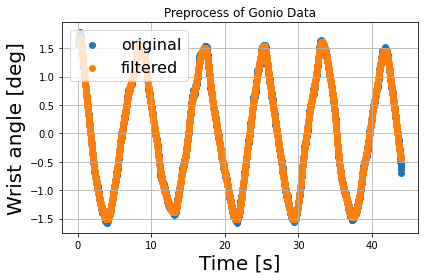

resampled_theta: 


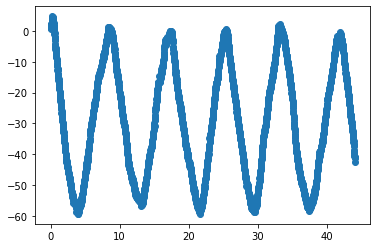

theta_zscore: 


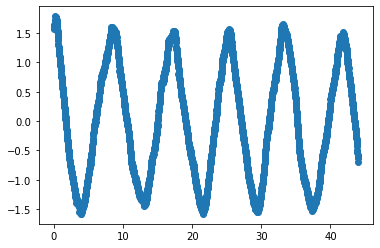

In [21]:
##### 図で確認

x = time
y1 = theta_before_low
y2 = theta_lowpass
print("x: ")
print(x.shape)
print("y1: ")
print(y1.shape)
print("y2: ")
print(y2.shape)

print("theta_before_low and theta_lowpass: ")
fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print("resampled_theta: ")
plt.scatter(time, resampled_theta, label='original')
plt.show()

print("theta_zscore: ")
plt.scatter(time, theta_zscore, label='normalized')
plt.show()

In [22]:
##### 処理データ・図の保存

theta = theta_lowpass

print("time: ")
print(time, time.shape)
print("theta: ")
print(theta, theta.shape)

# 前処理したゴニオデータを保存
with open(filtered_theta_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Gonio"])
    for i in range(theta.shape[0]):
        writer.writerow([time[i], theta[i]])
    f.close()
    
# フィルターをかける前後のデータの比較グラフを保存
fig.savefig(gonio_raw_vs_filtered_file_path)


time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
theta: 
[ 1.61534644  1.62305481  1.63053995 ... -0.43461218 -0.43848304
 -0.44174308] (2728,)


In [23]:


##############################     エコーデータの処理     ##############################



In [25]:
##### エコーデータ関連パス設定

print("Target Echo Data: " + echo_file)

# データ読み込み用パス
echo_path = data_per_info_path + "/EchoData"
target_echo_path = echo_path + "/" + echo_file

# データ前処理用パス
preprocessed_movie_path = echo_path + "/PreprocessedMovie/" + echo_file

# データ保存用パス
echo_processed_path = analysis_path + "/ProcessedData/EchoProcessed"
echo_raw_vs_filtered_file_path = echo_processed_path + "/EchoRawVSFiltered/" + echo_file.split(".")[0] + ".png"
filtered_fp_file_path = echo_processed_path + "/FilteredFP/" + echo_file.split(".")[0] + ".csv"
fp_for_analysis_file_path = echo_processed_path + "/FPForAnalysis/" + echo_file.split(".")[0] + ".csv"
fp_for_visualize_file_path = echo_processed_path + "/FPForVisualize/" + echo_file.split(".")[0] + ".csv"
opticalflow_movie_file_path = echo_processed_path + "/OpticalflowMovie/" + echo_file



print("target_echo_path: " + str(target_echo_path))


Target Echo Data: 20221108 135205.mp4
target_echo_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/EchoData/20221108 135205.mp4


In [26]:
##### 動画の前処理（実験データごとに最初の1回だけ実行する）
# 1. 動画時間を計測時間に合わせる（必要なフレーム数だけを保存）
# 2. 画像内の不要な部分を削る(スクリーン中のエコー部分のみ)


# preprocessed_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(preprocessed_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(target_echo_path)

    # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # フレームレート確認
    print("--Before Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    # 必要なフレームのみ取り出す
    start_frame = start_time * frame_rate # 876
    end_frame = end_time * frame_rate # 4088

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    new_size = (right - left, bottom - top)
    save = cv2.VideoWriter(preprocessed_movie_path, fmt, frame_rate, new_size)

    for i in range(end_frame):    # 1.の処理
        ret, frame = video.read()
        if ret == False:
            break
        if i < start_frame:
            continue

        frame = frame[top:bottom, left:right]   # 2.の処理
        frame = cv2.resize(frame, new_size)
        cv2.imshow("check frame", frame)
        key = cv2.waitKey(10)
        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        save.write(frame)

    save.release()
    video.release()
    cv2.destroyAllWindows()

    processed_video = cv2.VideoCapture(preprocessed_movie_path)
    # 動画情報
    width = int(processed_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(processed_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(processed_video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_video.release()
    print("--After Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    print("Preprocessing is done")
else:
    print("Processed Movie already Exists")

--Before Processing--
WIDTH: 1172, HEIGHT: 608
FRAME RATE: 62,
FRAME COUNT: 3975

--After Processing--
WIDTH: 1000, HEIGHT: 560
FRAME RATE: 62,
FRAME COUNT: 2728

Preprocessing is done


In [27]:
##### オプティカルフロー（解析ごとに最初の1回だけ実行する）

# opticalflow_movie_file_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_file_path):
    
    # 動画取得
    video = cv2.VideoCapture(preprocessed_movie_path)

    # Shi-Tomasi法のパラメータ（コーナー：物体の角を特徴点として検出）
    ft_params = dict(maxCorners=maxCorners,       # 特徴点の最大数
    qualityLevel=qualityLevel,    # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
    minDistance=minDistance,       # 特徴点間の最小距離
    blockSize=blockSize)         # 特徴点の計算に使うブロック（周辺領域）サイズ

    # Lucal-Kanade法のパラメータ（追跡用）
    lk_params = dict(winSize=(80,80),     # オプティカルフローの推定の計算に使う周辺領域サイズ
    maxLevel=4,          # ピラミッド数
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))       # 探索アルゴリズムの終了条件

    # # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS)) # 73, 62, 54, 48, or 43
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # 3212
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 最初のフレームを取得してグレースケール変換
    ret, frame = video.read()
    frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 最初のフレームのみさらにトリミング
    frame_pre_first = frame_pre[trim_h : height - trim_h, trim_w : width - trim_w]

    # Shi-Tomasi法で特徴点の検出
    feature_pre = cv2.goodFeaturesToTrack(frame_pre_first, mask=None, **ft_params)

    # 座標をトリミング前のものに修正
    for v in feature_pre:
        v[0][0] += trim_w
        v[0][1] += trim_h

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    frame_num = 0
    # 動画終了まで繰り返し
    while(video.isOpened() and frame_num < frame_count):

        # 次のフレームを取得し、グレースケールに変換
        ret, frame = video.read()
        if ret == False:
            break

        frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Lucas-Kanade法でフレーム間の特徴点のオプティカルフローを計算
        feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)

        # オプティカルフローを検出した特徴点を取得
        good1 = feature_pre[status == 1] # 1フレーム目
        good2 = feature_now[status == 1] # 2フレーム目

        # 座標を保存する配列を初期化、初期位置を保存
        if frame_num == 0:
            feature_points_of_all = np.empty([0, good1.shape[0], 2])
            feature_points_of_t = good1.reshape([1, good1.shape[0], 2])
            feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

            first_num = good1.shape[0]
            print("Num of feature point at first: " + str(first_num))

        # statusが0となるインデックスを取得
        vanish = np.where(status == 0)[0]

        # position_allからstatus=0の要素を削除
        for i, v in enumerate(vanish):
            # 最初のフレーム間で特徴点が消えている場合は何もしない
            if frame_num == 0:
                break
            feature_points_of_all = np.delete(feature_points_of_all, v - i, 1)

        # 各時刻における座標を保存
        feature_points_of_t = good2.reshape([1, good2.shape[0], 2])
        feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

        # 特徴点とオプティカルフローをフレーム・マスクに描画
        for i, (pt1, pt2) in enumerate(zip(good1, good2)):
            x1, y1 = pt1.ravel() # 1フレーム目の特徴点座標
            x2, y2 = pt2.ravel() # 2フレーム目の特徴点座標

            # 軌跡を描画（過去の軌跡も残すためにmaskに描く）
            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)

            # 現フレームにオプティカルフローを描画
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

        # フレームとマスクの論理積（合成）
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow('mask', img)

        # 次のフレーム、ポイントの準備
        frame_pre = frame_now.copy() # 次のフレームを最初のフレームに設定
        feature_pre = good2.reshape(-1, 1, 2) # 次の点を最初の点に設定

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        frame_num += 1

    last_num = good2.shape[0]
    print("Num of feature point at last: " + str(last_num) + "\n\n")

    # 終了処理
    cv2.destroyAllWindows()
    video.release()

    print("feature_points_of_all: ")
    print(feature_points_of_all, feature_points_of_all.shape)

else:
    print("Opticalflow Movie already exists.")

FRAME COUNT: 2728,
WIDTH: 1000, HEIGHT: 560

Num of feature point at first: 328
Num of feature point at last: 328


feature_points_of_all: 
[[[900.         182.        ]
  [814.         319.        ]
  [856.         319.        ]
  ...
  [694.         351.        ]
  [369.         157.        ]
  [801.         191.        ]]

 [[900.15985107 181.95594788]
  [814.06420898 318.94790649]
  [856.10559082 318.95233154]
  ...
  [694.15002441 350.96994019]
  [369.0609436  156.9732666 ]
  [801.13555908 190.93045044]]

 [[900.30114746 181.91687012]
  [814.11437988 318.92959595]
  [856.21789551 318.93215942]
  ...
  [694.19482422 350.94528198]
  [369.15963745 156.93273926]
  [801.33074951 190.84707642]]

 ...

 [[904.66845703 173.58070374]
  [825.08703613 318.28973389]
  [858.56152344 318.89266968]
  ...
  [713.71881104 351.43405151]
  [385.83609009 165.26266479]
  [828.44866943 193.24116516]]

 [[904.81225586 173.77027893]
  [825.0880127  318.28631592]
  [858.55505371 318.87808228]
  ...
  [713

In [28]:
##### 特徴点の選出（解析ごとに最初の1回だけ実行する）
##### 
# pattern1: 特徴点のうち相関係数の大きい座標データのみを取り出す
# pattern2: 特徴点のうちx,y座標の相関係数の平均の大きい順に特徴点を取り出す

# opticalflow_movie_file_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_file_path):

    print("特徴点選出パターン: " + str(fp_selection_pattern))
    
    print("feature_points_of_all: " + str(feature_points_of_all.shape))

    # 各特徴点の相関係数をリスト化
    coef_list = list()
    for i in range(feature_points_of_all.shape[1]):
        feature_point = feature_points_of_all[:, i, :]
        feature_point_x = feature_point[:, 0]
        feature_point_y = feature_point[:, 1]
        coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
        coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
        coef_ave = np.average([coef_x, coef_y])
        # 確認
        if i < 3:
            print("coef_x: " + str(coef_x))
            print("coef_y: " + str(coef_y))
            print("coef_ave: " + str(coef_ave))

        # 特徴点選出パターン
        if fp_selection_pattern == 1:
            # パターン１
            coef_list.append(max(coef_x, coef_y))
        elif fp_selection_pattern == 2:
            # パターン２
            coef_list.append(coef_ave)

    print("coef_list: " + str(len(coef_list)))
    # print(coef_list)

    # coef_listから相関係数の大きい順に並び変え，feature_num個だけ取り出す
    selection_list = sorted(coef_list, reverse=True)[:feature_num]
    print("selection_list: " + str(len(selection_list)))
    print(selection_list)

    # selection_listで取り出したものに該当する特徴点を選出する
    selected_feature_points = np.empty([feature_points_of_all.shape[0], 0, 2])
    feature_points_for_analysis = np.empty([feature_points_of_all.shape[0], 0])

    print(selected_feature_points.shape)
    for i in range(feature_points_of_all.shape[1]):
        feature_point = feature_points_of_all[:, i, :]
        feature_point_x = feature_point[:, 0]
        feature_point_y = feature_point[:, 1]
        coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
        coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
        coef_ave = np.average([coef_x, coef_y])

        # パターン⓵特徴点のうち相関係数の大きい座標データのみを取り出す
        # 特徴点選出パターン
        if fp_selection_pattern == 1:
            # パターン１
            if coef_x in selection_list:
                feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
                selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
                feature_point_x_reshape = feature_point_x.reshape([feature_point_x.shape[0], 1])
                feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_x_reshape, axis=1)
                # 確認
                if i < 30:
                    print("coef_x: " + str(coef_x))
            elif coef_y in selection_list:
                feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
                selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
                feature_point_y_reshape = feature_point_y.reshape([feature_point_y.shape[0], 1])
                feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_y_reshape, axis=1)
                # 確認
                if i < 30:
                    print("coef_y: " + str(coef_y))
        elif fp_selection_pattern == 2:
            # パターン２
            if coef_ave in selection_list:
                feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
                selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
    if fp_selection_pattern == 2:
        feature_points_for_analysis = selected_feature_points.reshape([selected_feature_points.shape[0], selected_feature_points.shape[1]*2])


    print("selected_feature_points: " + str(selected_feature_points.shape))
    print("feature_points_for_analysis: " + str(feature_points_for_analysis.shape))

特徴点選出パターン: 1
feature_points_of_all: (2728, 328, 2)
coef_x: 0.18722613279172481
coef_y: -0.3665087652981502
coef_ave: -0.08964131625321269
coef_x: -0.3473824575394745
coef_y: 0.5170953271793031
coef_ave: 0.08485643481991428
coef_x: -0.4939900478654756
coef_y: 0.5540045718699864
coef_ave: 0.030007262002255397
coef_list: 328
selection_list: 60
[0.8398666977698475, 0.8353087814016966, 0.8294070705556436, 0.8285839537633964, 0.8219345473801872, 0.8159408268969423, 0.8043392740952221, 0.8021181654393086, 0.8020196154618611, 0.8014760096079916, 0.8007389893460983, 0.7964031902852682, 0.7952729414185364, 0.7877783808013397, 0.7862648329091817, 0.7832979470037417, 0.7829816844704102, 0.7822194952882026, 0.7811088871476912, 0.7806576340916335, 0.779699759389709, 0.7747338226029857, 0.7699861410238451, 0.7659626556292395, 0.7652570837860472, 0.7643333360138606, 0.7641617972088502, 0.7631436538848296, 0.7583850091771489, 0.7582691683906437, 0.758256449284208, 0.7563412626958949, 0.7552115023657269

In [29]:
##### 特徴点の選出・csvファイルへの保存（解析ごとに最初の1回だけ実行する）


### feature_points の変数が孫座しない場合等に変更



# fp_for_visualize_file_pathが存在しない場合のみこのセルを実行
if not os.path.exists(fp_for_visualize_file_path):
    
    # データの形を修正
    feature_points_data = selected_feature_points.reshape(
        [selected_feature_points.shape[0], selected_feature_points.shape[1] * 2]) # (3212, 100)
    print("feature_points_data: ")
    print(feature_points_data, feature_points_data.shape)

    # 特徴点データを保存
    with open(fp_for_visualize_file_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Feature Points Data"])
        for each_time_data in feature_points_data:
            writer.writerow(each_time_data)
        f.close()
    print("Save completed")
    
    # 特徴点（片方座標）データを保存
    print("feature_points_for_analysis: ")
    print(feature_points_for_analysis, feature_points_for_analysis.shape)
    with open(fp_for_analysis_file_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Feature Points Data"])
        for each_time_data in feature_points_for_analysis:
            writer.writerow(each_time_data)
        f.close()
    print("Save completed")

else:
    print("Original FP already exists.")

feature_points_data: 
[[129.         159.         121.         ... 154.         639.
  154.        ]
 [128.98254395 158.96279907 120.96855164 ... 153.9566803  639.1194458
  153.96130371]
 [128.95578003 158.91638184 120.94710541 ... 153.92279053 639.34783936
  153.92684937]
 ...
 [142.93096924 158.88111877 137.94497681 ... 155.56945801 670.19647217
  154.36593628]
 [142.75598145 159.04139709 137.78140259 ... 155.59844971 669.91583252
  154.38720703]
 [142.60560608 159.22132874 137.60050964 ... 155.58633423 669.59350586
  154.3762207 ]] (2728, 120)
Save completed
feature_points_for_analysis: 
[[129.         121.         774.         ... 649.         662.
  639.        ]
 [128.98254395 120.96855164 774.10632324 ... 649.08892822 662.10388184
  639.1194458 ]
 [128.95578003 120.94710541 774.32080078 ... 649.31079102 662.33404541
  639.34783936]
 ...
 [142.93096924 137.94497681 756.5413208  ... 678.29669189 688.68115234
  670.19647217]
 [142.75598145 137.78140259 756.42193604 ... 678.0244751 

EchoData: 20221108 135205.mp4
GonioData: 202211081352.csv
feature_points_for_visualize: 
[[129.         159.         121.         ... 154.         639.
  154.        ]
 [128.98254395 158.96279907 120.96855164 ... 153.9566803  639.1194458
  153.96130371]
 [128.95578003 158.91638184 120.94710541 ... 153.92279053 639.34783936
  153.92684937]
 ...
 [142.93096924 158.88111877 137.94497681 ... 155.56945801 670.19647217
  154.36593628]
 [142.75598145 159.04139709 137.78140259 ... 155.59844971 669.91583252
  154.38720703]
 [142.60560608 159.22132874 137.60050964 ... 155.58633423 669.59350586
  154.3762207 ]] (2728, 120)
theta: 
[ 1.61534644  1.62305481  1.63053995 ... -0.43461218 -0.43848304
 -0.44174308] (2728,)


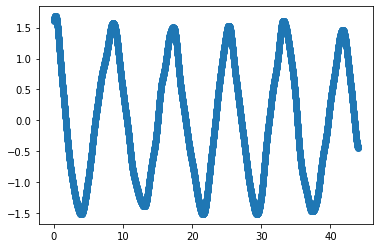

In [30]:
##### 特徴点データとゴニオデータの読み込み
# 要修正　特徴点選出の前に
# フォルダごと　selected_FPを追加する

print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(fp_for_visualize_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points_for_visualize = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points_for_visualize.append(row)
    f.close()

feature_points_for_visualize = np.array(feature_points_for_visualize).astype(float)[:, :]
# theta = np.array(theta).astype(float)[:]

print("feature_points_for_visualize: ")
print(feature_points_for_visualize, feature_points_for_visualize.shape)
print("theta: ")
print(theta, theta.shape)


plt.scatter(time, theta)
plt.show()

In [31]:
##### 選出した特徴点の描画・動画保存（解析ごとに最初の1回だけ実行する）

# opticalflow_movie_file_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_file_path):
    
    # 特徴点データを元の形に直す（1つの特徴点につきx,y座長の2データを持つ）
    feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num, 2]) # (3212, 50, 2)
    print("feature_points_for_visualize: ")
    print(feature_points_for_visualize, feature_points_for_visualize.shape)

    # 動画取得
    video = cv2.VideoCapture(preprocessed_movie_path)

    # 動画情報
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    save = cv2.VideoWriter(opticalflow_movie_file_path, fmt, frame_rate, size)

    # 最初のフレームを取得
    ret, frame = video.read()

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    # 最初の特徴点の座標を取得
    points_pre = feature_points_for_visualize[0] # (50, 2)

    # 動画終了まで繰り返し
    for t in range(feature_points_for_visualize.shape[0] - 1):

        # 現在のフレームを取得
        ret, frame = video.read()
        if ret == False:
            print("false t: " + str(t))
            break

        # 現在の特徴点の座標を取得
        points_now = feature_points_for_visualize[t+1]

        # 現在の関節角度を取得
        theta_now = round(theta[t], 2)

        # オプティカルフローと現在の特徴点をmask, frameに描画
        for p_pre, p_now in zip(points_pre, points_now):
            x1, y1 = p_pre[0], p_pre[1]
            x2, y2 = p_now[0], p_now[1]

            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

            # 関節角度情報を描画
            angle = "Wrist Angle: " + str(theta_now)
            # org = (20, 460) # 挿入する座標
            cv2.putText(frame, angle, wrist_angle_position, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(255, 255, 255))

        # frameとmaskの合成
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow("mask", img)

        # フレームごとに保存
        save.write(img)

        # 特徴点の更新
        points_pre = points_now

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    # 終了処理
    cv2.destroyAllWindows()
    video.release()
    save.release()

    print("Save completed")
    
    # 特徴点データを解析用の形に戻す
    feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num * 2]) # (3212, 100)

else:
    print("Opticalflow Mivie already exists.")

feature_points_for_visualize: 
[[[129.         159.        ]
  [121.         167.        ]
  [774.         170.        ]
  ...
  [649.         154.        ]
  [662.         154.        ]
  [639.         154.        ]]

 [[128.98254395 158.96279907]
  [120.96855164 166.95837402]
  [774.10632324 169.92355347]
  ...
  [649.08892822 153.96627808]
  [662.10388184 153.9566803 ]
  [639.1194458  153.96130371]]

 [[128.95578003 158.91638184]
  [120.94710541 166.90516663]
  [774.32080078 169.85098267]
  ...
  [649.31079102 153.93470764]
  [662.33404541 153.92279053]
  [639.34783936 153.92684937]]

 ...

 [[142.93096924 158.88111877]
  [137.94497681 168.7066803 ]
  [756.5413208  175.61134338]
  ...
  [678.29669189 153.55149841]
  [688.68115234 155.56945801]
  [670.19647217 154.36593628]]

 [[142.75598145 159.04139709]
  [137.78140259 168.87214661]
  [756.42193604 175.6665802 ]
  ...
  [678.0244751  153.57299805]
  [688.39074707 155.59844971]
  [669.91583252 154.38720703]]

 [[142.60560608 159.221

EchoData: 20221108 135205.mp4

--Before Processing--


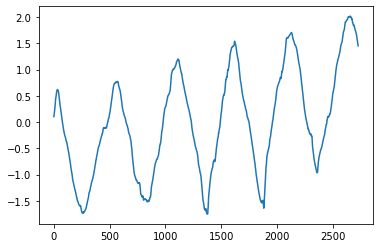

(2728, 60)
(2728,)

--After Processing--
processed_feature_points: 
[[-0.70631965 -1.04335969  1.62984084 ...  0.1479088   0.12603803
   0.10369184]
 [-0.70895802 -1.04842772  1.64084943 ...  0.15181707  0.13078586
   0.10895248]
 [-0.7130032  -1.05188387  1.6630562  ...  0.16156762  0.14130529
   0.11901142]
 ...
 [ 1.39925216  1.68739276 -0.17781182 ...  1.43545625  1.34547731
   1.47765113]
 [ 1.37280393  1.6610321  -0.19017279 ...  1.42349271  1.33220459
   1.46529116]
 [ 1.35007571  1.63188046 -0.19596147 ...  1.41039452  1.31942561
   1.45109521]] (2728, 60)
x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[-0.70631965 -0.70895802 -0.7130032  ...  1.39925216  1.37280393
  1.35007571] (2728,)
y2: 
[-0.70631965 -0.70895802 -0.7130032  ...  1.39925216  1.37280393
  1.35007571] (2728,)


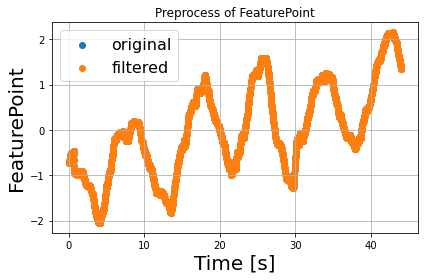

Save completed


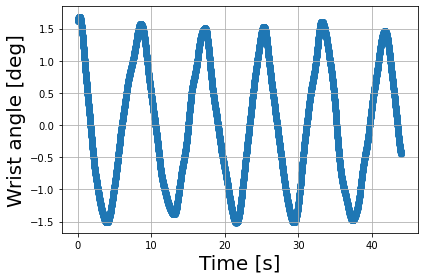

In [32]:
##### 特徴点データの処理・保存
print("EchoData: " + echo_file)

print("\n--Before Processing--")
# print("feature_points: ")
# print(feature_points, feature_points.shape)

with open(fp_for_analysis_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points.append(row)
    f.close()
feature_points = np.array(feature_points).astype(float)[:, :]

# 正規化
select_normalize_position = 2
#1:正規化しない、2:正規化する

if select_normalize_position==1:
    processed_feature_points = feature_points

if select_normalize_position==2:
   
    data_fp = feature_points
    processed_feature_points = feature_points

    #NumPyで配列の正規化(normalize)、標準化する方法
    #https://deepage.net/features/numpy-normalize.html
    import numpy as np
    def zscore(x, axis = None):
        xmean = x.mean(axis=axis, keepdims=True)
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore, xmean, xstd

    #すべての特徴点の正規化
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(data_fp[:,i])
        processed_feature_points[:,i] = fp_part

    plt.plot(fp_part)
    plt.show()

    print('===============')
    print(feature_points.shape)
    print(fp_part.shape)
    print('===============')
    

# ローパスフィルタ
#フィルター選択(角度情報)
#1: raw, 2:lowpath
filter_select = 1

#ローパス
samplerate = 30
fp_l = 0.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs_l = 2.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass_l = 3 # 通過域端最大損失[dB]
gstop_l = 40 # 阻止域端最小損失[dB]
from scipy import signal
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

if filter_select == 2:
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(processed_feature_points[:,i])
        fp_part_low = lowpass(fp_part, samplerate, fp_l, fs_l, gpass_l, gstop_l)
        plt.scatter(time,fp_part_low,s=5)

        processed_feature_points[:,i] = fp_part_low


# 特徴点データを保存
with open(filtered_fp_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Processed Feature Points Data"])
    for each_time_data in processed_feature_points:
        writer.writerow(each_time_data)
    f.close()
    

print("\n--After Processing--")
print("processed_feature_points: ")
print(processed_feature_points, processed_feature_points.shape)


# 比較グラフの表示・保存（Noつ目の特徴点のみ）

No = 0
x = time
y1 = feature_points[:, No]
y2 = processed_feature_points[:, No]

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig = plt.figure()
plt.title("Preprocess of FeaturePoint")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("FeaturePoint", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(echo_raw_vs_filtered_file_path)

print("Save completed")

plt.scatter(time, theta)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:


##############################     解析     ##############################



In [34]:
##### 結果保存用パス設定

fp_behavior_file_path = analysis_path + "/Results/FPBehavior/" + gonio_file.split(".")[0]
angle_estimation = analysis_path + "/Results/AngleEstimation/" + gonio_file.split(".")[0]



In [35]:
##### データ読み込み

print("EchoData : " + echo_file)
print("GonioData: " + gonio_file)

with open(filtered_fp_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    X = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        X.append(row)
    f.close()

X = np.array(X).astype(float)[:, :]
theta = np.array(theta).astype(float)[:, np.newaxis]

print("X: ")
print(X, X.shape)
print("theta: ")
print(theta, theta.shape)

EchoData : 20221108 135205.mp4
GonioData: 202211081352.csv
X: 
[[-0.70631965 -1.04335969  1.62984084 ...  0.1479088   0.12603803
   0.10369184]
 [-0.70895802 -1.04842772  1.64084943 ...  0.15181707  0.13078586
   0.10895248]
 [-0.7130032  -1.05188387  1.6630562  ...  0.16156762  0.14130529
   0.11901142]
 ...
 [ 1.39925216  1.68739276 -0.17781182 ...  1.43545625  1.34547731
   1.47765113]
 [ 1.37280393  1.6610321  -0.19017279 ...  1.42349271  1.33220459
   1.46529116]
 [ 1.35007571  1.63188046 -0.19596147 ...  1.41039452  1.31942561
   1.45109521]] (2728, 60)
theta: 
[[ 1.61534644]
 [ 1.62305481]
 [ 1.63053995]
 ...
 [-0.43461218]
 [-0.43848304]
 [-0.44174308]] (2728, 1)


In [36]:
##### 学習データ・テストデータの分割

# 訓練データとテストデータの区切り位置
devide_num = X.shape[0] * 4 // 5

print(devide_num)

X_train = X[:devide_num]
theta_train = theta[:devide_num]

print("devide_num: " + str(devide_num))
print("X_train: ")
print(X_train, X_train.shape)
print("theta_train: ")
print(theta_train, theta_train.shape)

2182
devide_num: 2182
X_train: 
[[-0.70631965 -1.04335969  1.62984084 ...  0.1479088   0.12603803
   0.10369184]
 [-0.70895802 -1.04842772  1.64084943 ...  0.15181707  0.13078586
   0.10895248]
 [-0.7130032  -1.05188387  1.6630562  ...  0.16156762  0.14130529
   0.11901142]
 ...
 [ 0.82164403  0.98069112  0.11553368 ...  1.36700121  1.37913335
   1.35755405]
 [ 0.80548635  0.96493374  0.08429001 ...  1.35475871  1.36779937
   1.34532311]
 [ 0.79103992  0.95138948  0.05006984 ...  1.34095504  1.3547526
   1.32970514]] (2182, 60)
theta_train: 
[[ 1.61534644]
 [ 1.62305481]
 [ 1.63053995]
 ...
 [ 0.04273891]
 [ 0.01785101]
 [-0.00709031]] (2182, 1)


In [37]:
##### 重みの導出

#最小事情法で正則化するか
#1:正則化なし、2:正則化あり
regularize_select = 2

X_T = X_train.T
X_T_X = np.dot(X_T, X_train)
I = np.eye(X_T_X.shape[0])

if regularize_select==1:
    inv = np.linalg.pinv(X_T_X)

if regularize_select==2:
    inv = np.linalg.pinv(X_T_X + lam * I)

W = np.dot(np.dot(inv, X_T), theta_train)

W_reshape = W.reshape(-1)
W_max_index = np.argmax(W_reshape)
W_max = np.max(W_reshape)
W_min_index = np.argmin(W_reshape)
W_min = np.min(W_reshape)

print("X_T: " + str(X_T.shape))
print("X_T_X: " + str(X_T_X.shape))
print("inv: " + str(inv.shape))
print("W: " + str(W.shape))
# print(W)
print("W_max: ")
print("index: " + str(W_max_index) + " value: " + str(W_max))
print("W_min: ")
print("index: " + str(W_min_index) + " value: " + str(W_min))

X_T: (60, 2182)
X_T_X: (60, 60)
inv: (60, 60)
W: (60, 1)
W_max: 
index: 45 value: 0.9119336154698547
W_min: 
index: 26 value: -0.8169153026067904


angle: 
(2728,)
X_max: 
(2728,)
X_min: 
(2728,)


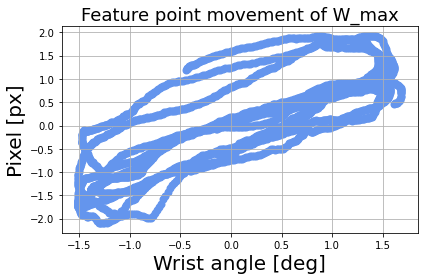

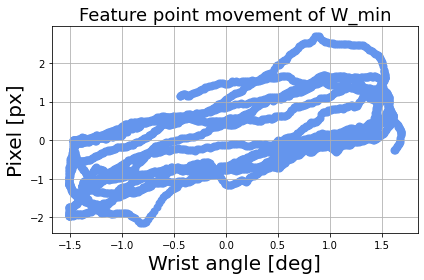

Save completed


In [38]:
##### 関節角度-特徴点座標のグラフを作成・保存

angle = theta.reshape(-1)
# 重みが最大・最小となっている特徴点のみ取り出す
X_max = X[:, W_max_index]
X_min = X[:, W_min_index]

print("angle: ")
print(angle.shape)
print("X_max: ")
print(X_max.shape)
print("X_min: ")
print(X_min.shape)

def Visualize(x, y, save_path, max_or_min):
    fig = plt.figure()
    plt.title("Feature point movement of W_" + max_or_min, fontsize=18)
    plt.xlabel("Wrist angle [deg]", fontsize=20)
    plt.ylabel("Pixel [px]", fontsize=20)
    plt.scatter(x, y, color="cornflowerblue", linewidth=2, label="Feature Point Movement")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path + max_or_min + ".png")
    plt.close()

Visualize(angle, X_max, fp_behavior_file_path, "max")
Visualize(angle, X_min, fp_behavior_file_path, "min")

print("Save completed")

In [39]:
##### 関節角度の推定値を導出

theta_pred = np.dot(X, W)

print("theta_pred: ")
print(theta_pred, theta_pred.shape)

theta_pred: 
[[ 1.61429423]
 [ 1.61337519]
 [ 1.61351866]
 ...
 [-0.38684537]
 [-0.39573937]
 [-0.40876881]] (2728, 1)


x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[ 1.61534644  1.62305481  1.63053995 ... -0.43461218 -0.43848304
 -0.44174308] (2728,)
y2: 
[ 1.61429423  1.61337519  1.61351866 ... -0.38684537 -0.39573937
 -0.40876881] (2728,)


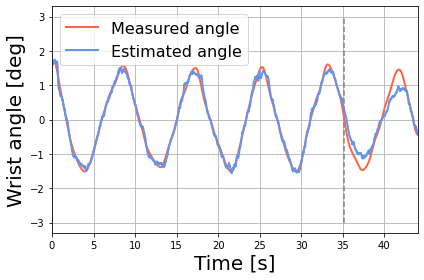

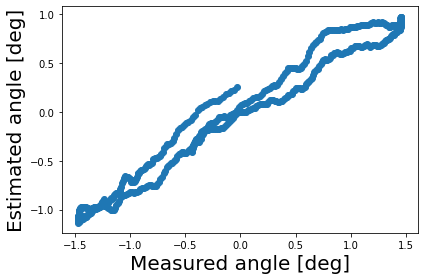

In [40]:
##### グラフ作成・保存

x = time
y1 = theta.reshape(-1)
y2 = theta_pred.reshape(-1)

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig1 = plt.figure()
# plt.title("A result of estimating wrist joint angle", fontsize=18)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.plot(x, y1, color="tomato", linewidth=2, label="Measured angle")
plt.plot(x, y2, color="cornflowerblue", linewidth=2, label="Estimated angle")
line_position = devide_num / echo_frame_rate

#plt.vlines(line_position, min_height, max_height, "gray", linestyles="dashed")
plt.vlines(line_position, -3, 3, "gray", linestyles="dashed")

#plt.ylim(min_height, max_height) #extensor

plt.xlim(0, x.shape[0] / echo_frame_rate)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig(angle_estimation + "_estimation.png")

fig2 = plt.figure()
# plt.title("Scatter plots of estimated and measured angle", fontsize=16)
plt.xlabel("Measured angle [deg]", fontsize=20)
plt.ylabel("Estimated angle [deg]", fontsize=20)
plt.scatter(y1[devide_num:], y2[devide_num:])
plt.tight_layout()
fig2.savefig(angle_estimation + "_scatter.png")

plt.show()
plt.close()

In [41]:
##### RMSE，決定係数R2，相関係数coeffを導出

theta_test = theta.reshape(-1)[devide_num:]
theta_pred_test = theta_pred.reshape(-1)[devide_num:]

T = theta_test.shape[0]
L = np.sum((theta_test - theta_pred_test)**2)
RMSE = np.sqrt(L/T)


if select_normarize_joint == 2:
    RMSE = float(theta_std*RMSE)

R2 = r2_score(theta_test, theta_pred_test)

coef = np.corrcoef(theta_test, theta_pred_test)[0][1]

print("theta_test: ")
print(theta_test.shape)
print("theta_pred_test: ")
print(theta_pred_test.shape)
print("T: " + str(T))
print("L: " + str(L))
print("RMSE: " + str(RMSE))
    
print("決定係数 R2: " + str(R2))
print("相関係数: " + str(coef) + "\n")

theta_test: 
(546,)
theta_pred_test: 
(546,)
T: 546
L: 51.410360811803486
RMSE: 5.840221645731747
決定係数 R2: 0.8960397397899423
相関係数: 0.9852640914574979



In [42]:
##### 結果の保存

target_data.loc[:, ["RMSE"]] = RMSE
target_data.loc[:, ["R2"]] = R2
target_data.loc[:, ["Corrcoef"]] = coef

print(target_data.loc[:, ["RMSE"]])
print(target_data.loc[:, ["R2"]])
print(target_data.loc[:, ["Corrcoef"]])

# 全データのデータフレームを更新
datasheet_all.update(target_data)

# 全データのデータシートに記入
datasheet_all.to_csv(datasheet_all_path, encoding="shift_jis", index=False)


# # print(target_data)

print("Save completed")

       RMSE
5  5.840222
        R2
5  0.89604
   Corrcoef
5  0.985264
Save completed
